# 练习8：异常检测和推荐系统

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import scipy.optimize as opt 

## Anomaly detection 异常检测

### 查看数据

In [2]:
data = sio.loadmat('./data/ex8data1.mat')
X = data['X']
Xval = data['Xval']
yval = data['yval']
X.shape, Xval.shape, yval.shape

((307, 2), (307, 2), (307, 1))

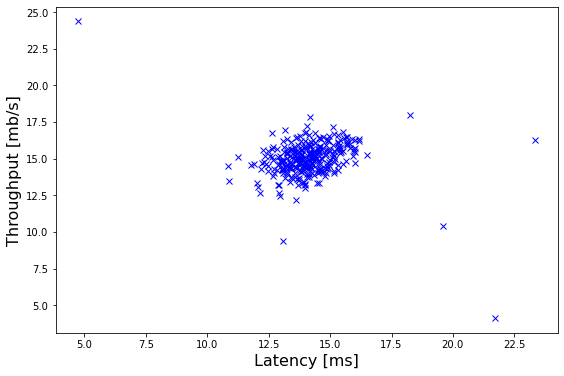

In [3]:
plt.figure(figsize=(9,6))
plt.plot(X[:,0],X[:,1],'bx')
plt.xlabel('Latency [ms]',fontsize=16)
plt.ylabel('Throughput [mb/s]',fontsize=16)
plt.show()

### Gaussian distribution 高斯分布模型
一般高斯分布模型如下：
<img src="./img/gaus.png">

我们知道，一般高斯分布是多元高斯分布的一个特例，也就是协方差矩阵为对角矩阵的时候。

所以，这里直接上多元高斯分布

多元高斯分布模型如下：
<img src="./img/gaus_high_dimention.png">

In [4]:
def gaus(X,mu,sigma):
    
    m = X.shape[0] # 样本数
    n = X.shape[1] # 特征数
    # 协方差矩阵simga 维度 n*n 
    # 均值向量 mu 维度 1*n
    
    # np.linalg.inv()求矩阵逆 
    sigma_inv = np.linalg.inv(sigma)
    # np.linalg.det()求矩阵行列式
    left = 1./(np.power((2*np.pi), n/2) * np.sqrt(np.linalg.det(sigma)))
    exp = np.zeros((m,1))
    for i in range(m):
        xi = X[i]
        # 这里计算出的是一个数，因为 (1*n) * (n*n) *(n*1) = (1,1)
        # 注意： xi-mu 是(1*n)是因为把它当做列向量了
        exp[i] = np.exp(-0.5 * (xi-mu).T.dot(sigma_inv).dot(xi-mu)) 
    return left * exp # 返回的是 m*1 维

In [5]:
# 参数估计
def estimate_gaussian(X):
    m = X.shape[0] # 样本数
    mu = np.mean(X, axis=0)
    sigma = ((X-mu).T.dot(X-mu))/float(m) 
    return mu,sigma

In [6]:
mu,sigma = estimate_gaussian(X)
mu,sigma

(array([14.11222578, 14.99771051]),
 array([[ 1.83263141, -0.22712233],
        [-0.22712233,  1.70974533]]))

In [7]:
gaus(X,mu,sigma).shape

(307, 1)

### 绘图展示

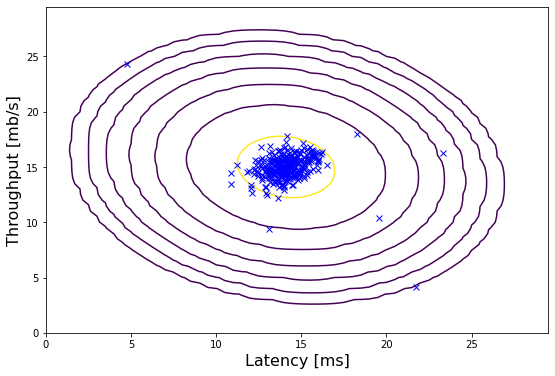

In [8]:
X_plt = np.arange(0,30,0.5)
y_plt = np.arange(0,30,0.5)
meshx, meshy = np.meshgrid(X_plt, y_plt)
coord_list = [ entry.ravel() for entry in (meshx, meshy) ]
points = np.vstack(coord_list).T
z_plt = np.array(gaus(points,mu,sigma))
z_plt = z_plt.reshape((X_plt.shape[0],X_plt.shape[0]))
cont_levels = [10**exp for exp in range(-20,0,3)]

plt.figure(figsize=(9,6))
plt.plot(X[:,0],X[:,1],'bx')
plt.xlabel('Latency [ms]',fontsize=16)
plt.ylabel('Throughput [mb/s]',fontsize=16)
mycont = plt.contour(meshx, meshy, z_plt, levels=cont_levels)
plt.show()

### Selecting the threshold,  $\epsilon$ 也就是阈值

In [35]:
def select_threshold(cv_gaus,yval):
    # 选取 epsilon 范围
    epsilon_list = np.linspace(np.min(cv_gaus),np.max(cv_gaus),num=1024)
    best_F1,best_eps = 0,0
    for eps in epsilon_list:
        cv_pred = np.array([1 if cv < eps  else 0 for cv in cv_gaus])
        cv_pred = cv_pred.reshape(cv_pred.shape[0],1)
        
        tp = np.sum([1 for i in range(cv_pred.shape[0]) if int(cv_pred[i]) == 1 and int(yval[i]) ==1])
        fn = np.sum([1 for i in range(cv_pred.shape[0]) if int(cv_pred[i]) == 0 and int(yval[i]) ==1]) 
        P = 0. if np.sum(cv_pred)==0. else tp / np.sum(cv_pred)
        R = tp / (tp+fn)
        F1 = 0. if (P+R)==0 else (2*P*R)/(P+R)
        if F1 > best_F1:
            best_F1 = F1
            best_eps = eps
    
    return best_F1, best_eps


In [36]:
cv_gaus = gaus(Xval, mu, sigma)

best_F1, best_eps = select_threshold(cv_gaus,yval)
best_F1, best_eps
# You should see a value for epsilon of about 8.99e-05.

(0.8750000000000001, 8.861944993541287e-05)

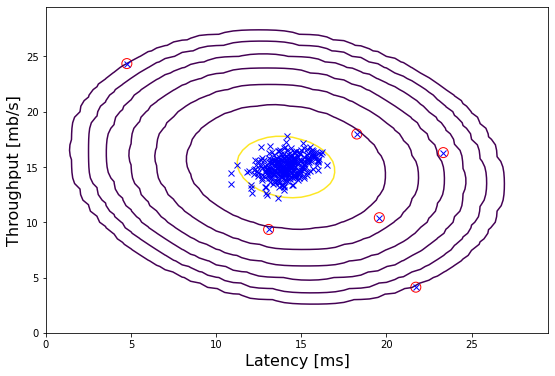

In [37]:
plt.figure(figsize=(9,6))
plt.plot(X[:,0],X[:,1],'bx')
plt.xlabel('Latency [ms]',fontsize=16)
plt.ylabel('Throughput [mb/s]',fontsize=16)
mycont = plt.contour(meshx, meshy, z_plt, levels=cont_levels)

# 获取异常点
X_gaus = gaus(X, mu, sigma)
anomsous = np.array([X[i] for i in range(X.shape[0]) if X_gaus[i] < best_eps])
# 绘制异常点
plt.scatter(anomsous[:,:1],anomsous[:,1:], s=100, facecolors='none',edgecolors='r')

plt.show()

### 应用到高维数据

In [38]:
data2 = sio.loadmat('./data/ex8data2.mat')
X_2 = data2['X']
Xval_2 = data2['Xval']
yval_2 = data2['yval']
X_2.shape, Xval_2.shape, yval_2.shape

((1000, 11), (100, 11), (100, 1))

In [39]:
mu_2,sigma_2 = estimate_gaussian(X_2)

cv_gaus_2 = gaus(Xval_2, mu_2, sigma_2)

best_F1_2, best_eps_2 = select_threshold(cv_gaus_2,yval_2)
best_F1_2, best_eps_2

(0.5517241379310345, 1.7144172739951688e-18)

In [40]:
X_gaus_2 = gaus(X_2, mu_2, sigma_2)
anomsous_2 = np.array([X_2[i] for i in range(X_2.shape[0]) if X_gaus_2[i] < best_eps_2])
print("异常点有 %d 个"%anomsous_2.shape[0])

异常点有 120 个


## Recommender Systems 推荐系统

### 查看数据

In [42]:
data3 = sio.loadmat('./data/ex8_movies.mat')
Y = data3['Y'] # num movies × num users matrix
R = data3['R'] # an binary-valued indicator matrix
Y.shape,R.shape

((1682, 943), (1682, 943))

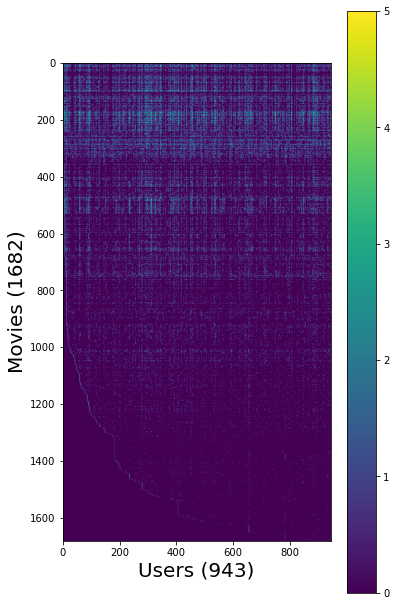

In [46]:
fig = plt.figure(figsize=(6,6*(Y.shape[0]/Y.shape[1])))
dummy = plt.imshow(Y)
dummy = plt.colorbar()
dummy = plt.ylabel('Movies (%d)'%Y.shape[0],fontsize=20)
dummy = plt.xlabel('Users (%d)'%Y.shape[1],fontsize=20)

### Collaborative filtering 协同过滤
代价函数
<img src="./img/cofi_cost_func.png">